In [1]:
import time
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.metrics import plot_confusion_matrix

# Data Preparation

In [2]:
# Mount gdrive
from google.colab import drive, files
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [3]:
# Specify input file location
training_file = 'gdrive/My Drive/shopee/train.csv'
test_file = 'gdrive/My Drive/shopee/test.csv'
user_file = 'gdrive/My Drive/shopee/users.csv'

In [4]:
# Load dataset
training_data = pd.read_csv(training_file)
test_data = pd.read_csv(test_file)
user_data = pd.read_csv(user_file)

In [5]:
# Merge with user data
training_data = pd.merge(training_data, user_data, on='user_id', how='inner')
test_data = pd.merge(test_data, user_data, on='user_id', how='inner')

In [6]:
# Change column type in training data
training_data['country_code'] = training_data['country_code'].astype('str')
training_data['attr_3'] = training_data['attr_3'].astype('str')
training_data['grass_date'] = pd.to_datetime(
    training_data.grass_date, 
    format='%Y-%m-%d %H:%M:%S', 
    errors='coerce'
)

# Change column type in test data
test_data['country_code'] = test_data['country_code'].astype('str')
test_data['attr_3'] = test_data['attr_3'].astype('str')
test_data['grass_date'] = pd.to_datetime(
    test_data.grass_date, 
    format='%Y-%m-%d %H:%M:%S', 
    errors='coerce'
)

In [7]:
# Specify input variables
variables = [
    'country_code',
    'subject_line_length', 
    'open_count_last_10_days',
    'open_count_last_30_days',
    'open_count_last_60_days'
]

In [8]:
# Data selection
x = training_data[variables]
y = training_data['open_flag']
x_test = test_data[variables]

In [9]:
# Encode categorical variables
x = pd.get_dummies(x)
x_test = pd.get_dummies(x_test)

In [10]:
# Split the data into training and validation set
x_train, x_validation, y_train, y_validation = train_test_split(
    x, 
    y, 
    test_size=0.2
)

# Modeling

In [11]:
# Define classifier
classifier = RandomForestClassifier()

In [12]:
# Specify the list of hyperparameters
hyperparameters = {
    "max_depth": [12, 9, 6, 3],
    "criterion": ["gini", "entropy"],
    "n_estimators": [10, 50, 100, 200],
    "min_samples_leaf": [50, 100, 200, 500],
    "class_weight": [{0:1.0, 1:1.0}, {0:1.0, 1:2.0}, {0:1.0, 1:3.0}]
}

In [13]:
# Define the model selection method
mcc_scorer = make_scorer(matthews_corrcoef)
model_selection = GridSearchCV(
    classifier, 
    hyperparameters, 
    cv=5, 
    scoring=mcc_scorer
)

In [14]:
# Find the best hyperparameters
start = time.time()
model_selection.fit(x, y)
time.time() - start

3698.684300661087

In [15]:
# Show the best hyperparameters
model_selection.best_params_

{'class_weight': {0: 1.0, 1: 2.0},
 'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 100,
 'n_estimators': 100}

In [16]:
# Show the best score
model_selection.best_score_

0.5161767818743824

In [17]:
# Train the classifier using the best hyperparameters
classifier = RandomForestClassifier(
    n_estimators=model_selection.best_params_['n_estimators'],
    class_weight=model_selection.best_params_['class_weight'],
    criterion=model_selection.best_params_['criterion'],
    max_depth=model_selection.best_params_['max_depth'],
    min_samples_leaf=model_selection.best_params_['min_samples_leaf']
)
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 2.0}, criterion='entropy',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=100,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [18]:
# Evaluate the model using the evaluation set
y_prediction = classifier.predict(x_validation)
print("MCC\t\t: %.4f" % matthews_corrcoef(y_validation, y_prediction))

MCC		: 0.5311


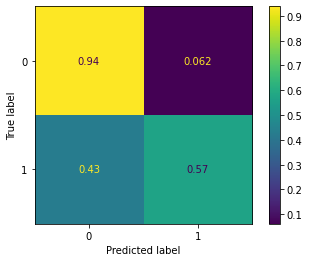

In [19]:
# Evaluate the model using confusion matrix
plot_confusion_matrix(classifier, x_validation, y_validation, normalize='true');

# Submission

In [20]:
# Retrain the classifier with all training data
classifier = RandomForestClassifier(
    n_estimators=model_selection.best_params_['n_estimators'],
    class_weight=model_selection.best_params_['class_weight'],
    criterion=model_selection.best_params_['criterion'],
    max_depth=model_selection.best_params_['max_depth'],
    min_samples_leaf=model_selection.best_params_['min_samples_leaf']
)
classifier.fit(x, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 2.0}, criterion='entropy',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=100,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [21]:
# Generate prediction
prediction = classifier.predict(x_test)
test_data['open_flag'] = prediction

In [22]:
# Generate submission file
test_data.loc[:, ['row_id', 'open_flag']].to_csv('submission.csv', index=False)